### Keras & TensorFlow to Predict Market Movements and Backtesting

In [1]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import Sequential
from talib import RSI, BBANDS, MACD

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

/Users/ihobbang/miniforge3/envs/main/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
/var/folders/82/yjz_v88n7jnb6641bk83qtvw0000gn/T/ipykernel_16314/2636440971.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [2]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 데이터 수집

In [3]:
# download ticker stock price from yahoo finance
stock = pd.read_csv('./Data/kodex200_data.csv')
stock['날짜'] = pd.to_datetime(stock['날짜'])
stock.set_index('날짜', inplace=True)
stock.rename(columns = {'종가':'close'}, inplace=True)
stock = stock.loc[:, ['close']]
stock.head(2)

,close
날짜,
2013-01-04,26870
2013-01-07,26885


In [4]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock['close'] / stock['close'].shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,close,returns,direction
날짜,,,
2013-01-07,26885,0.000558,1
2013-01-08,26600,-0.010657,-1
2013-01-09,26500,-0.003766,-1


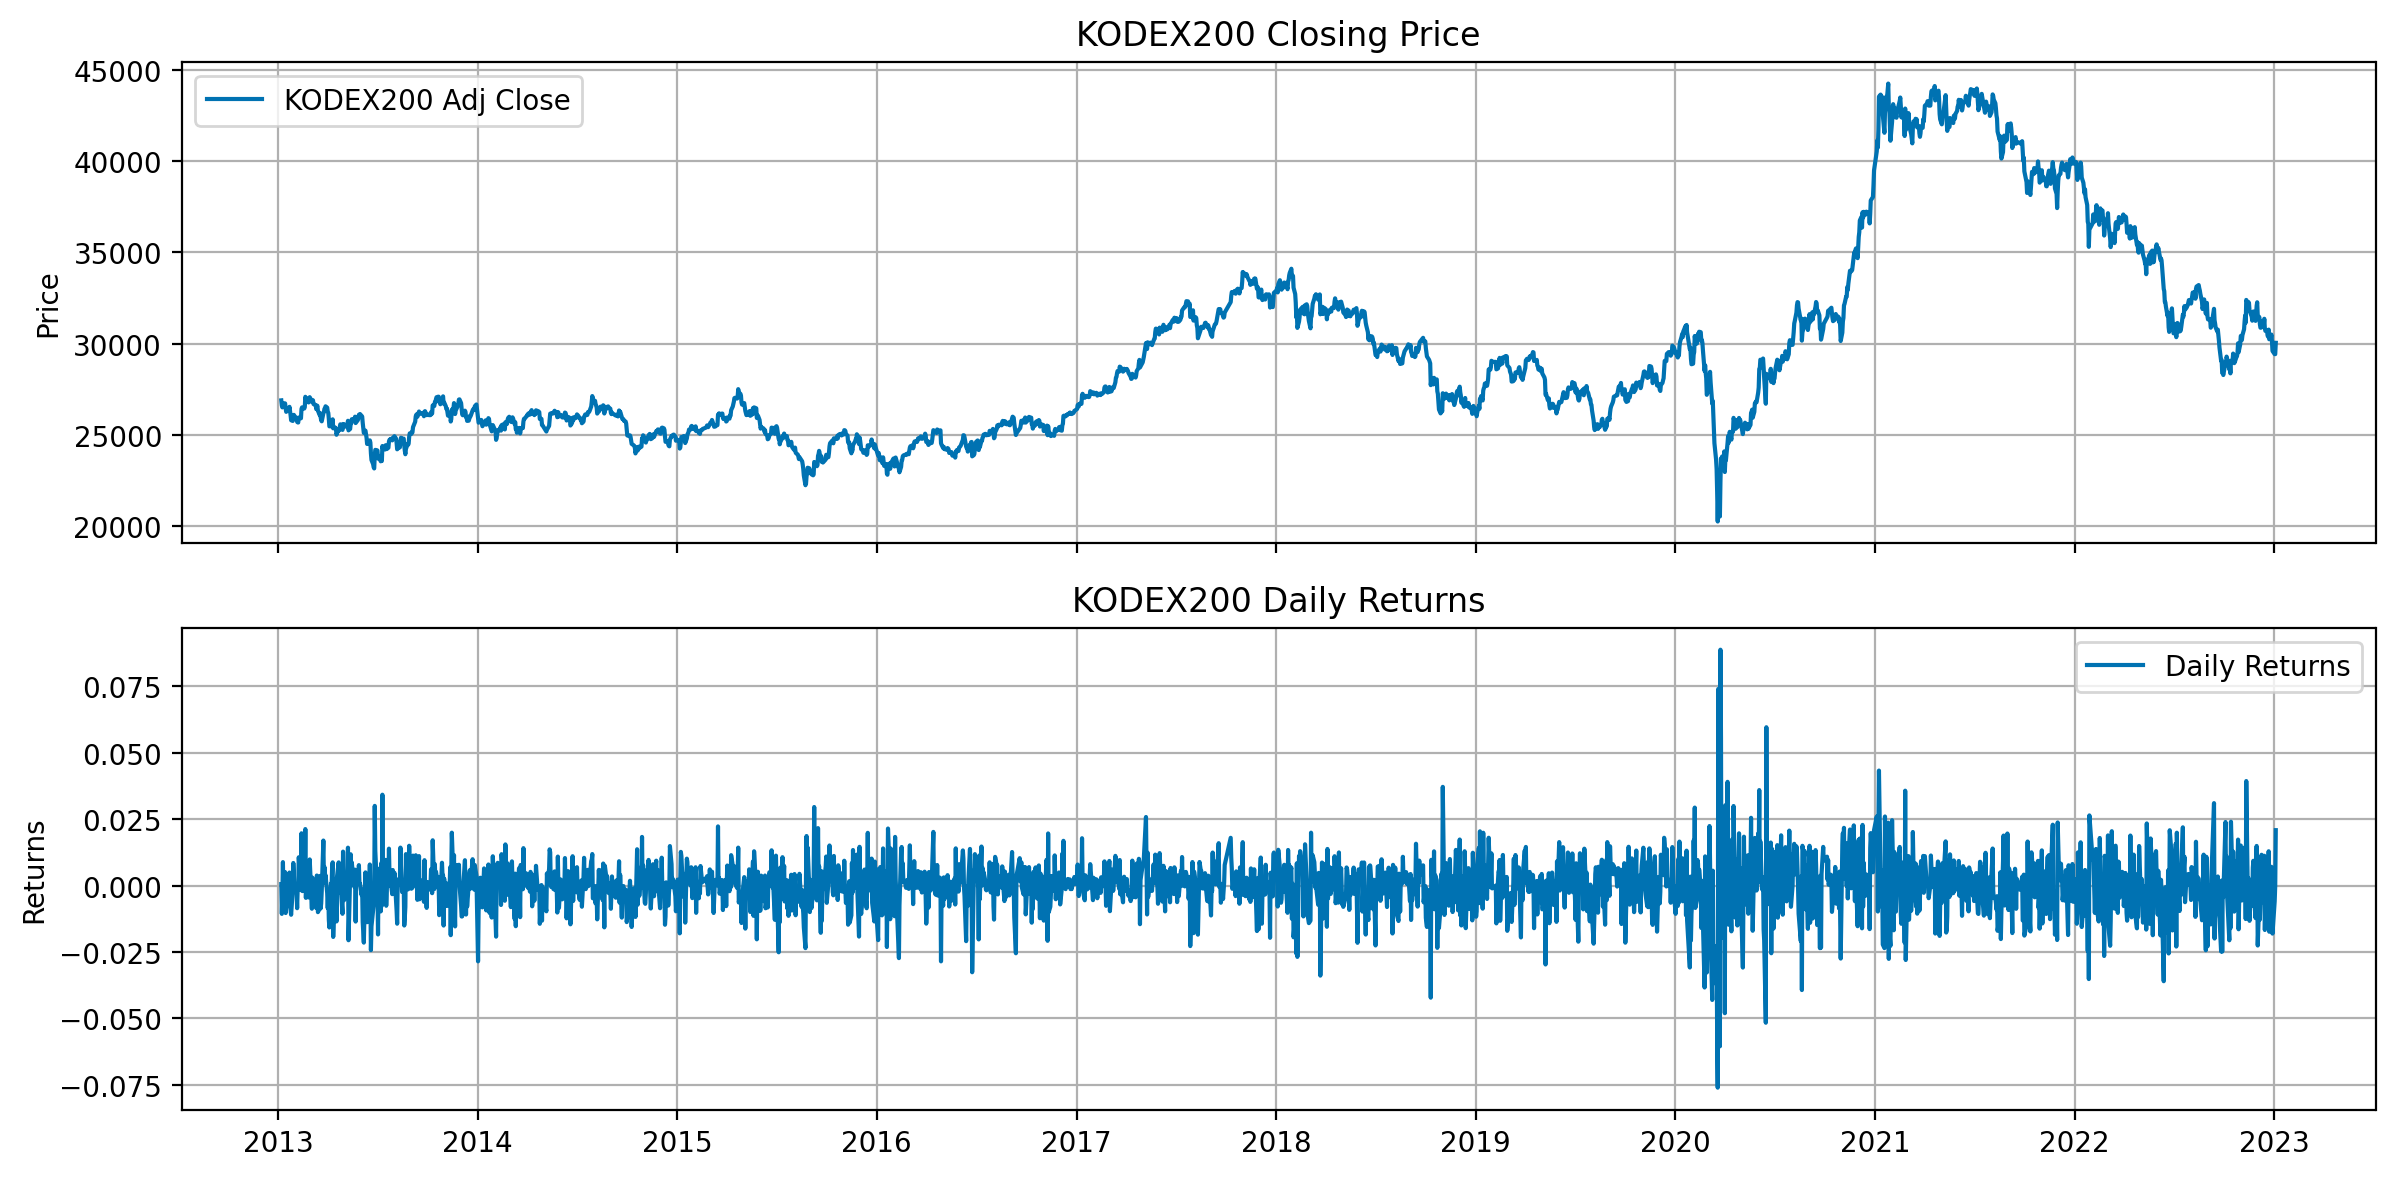

In [5]:
# visualize the closing price and daily returns
ticker = 'KODEX200'
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock['close'], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Returns', ylabel = 'Returns')
ax[1].legend()
ax[1].grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Feature Engineering

In [6]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [7]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.head(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
날짜,,,,,,,,
2013-01-07,26885,0.000558,1,NaN,NaN,NaN,NaN,NaN
2013-01-08,26600,-0.010657,-1,0.000558,NaN,NaN,NaN,NaN


In [8]:
# RSI - Relative Strenght Index
stock['rsi'] = RSI(stock.close)

# append to feature columns list
cols.append('rsi')
stock.tail(2)

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi
날짜,,,,,,,,,
2023-01-03,29420,0.000000,0,-0.005931,-0.018082,-0.011875,0.007075,0.001487,33.147497
2023-01-04,30040,0.020855,1,0.000000,-0.005931,-0.018082,-0.011875,0.007075,43.618207


In [9]:
# Compute Bollinger Bands
high, mid, low = BBANDS(stock.close, timeperiod=20)
stock = stock.join(pd.DataFrame({'bb_high': high, 'bb_low': low}, index=stock.index))

# append to feature columns list
cols.append('bb_high')
cols.append('bb_low')

In [10]:
# Compute Moving Average Convergence/ Divergence
stock['macd'] = MACD(stock.close)[0]

# append to feature columns list
cols.append('macd')

In [11]:
# # let's look at the head and tail of our dataframe
stock.tail()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
날짜,,,,,,,,,,,,
2022-12-28,30135,-0.011875,-1,0.007075,0.001487,-0.017377,0.012922,-0.002466,40.164281,31892.780539,29870.719461,-230.293040
2022-12-29,29595,-0.018082,-1,-0.011875,0.007075,0.001487,-0.017377,0.012922,34.716600,31696.597378,29799.902622,-291.477748
2023-01-02,29420,-0.005931,-1,-0.018082,-0.011875,0.007075,0.001487,-0.017377,33.147497,31681.275709,29602.724291,-350.052916
2023-01-03,29420,0.000000,0,-0.005931,-0.018082,-0.011875,0.007075,0.001487,33.147497,31640.196565,29441.303435,-391.955934
2023-01-04,30040,0.020855,1,0.000000,-0.005931,-0.018082,-0.011875,0.007075,43.618207,31585.022270,29395.977730,-370.860510


### Build and Apply the Model

In [12]:
# split the dataset in training and test datasets
train, test = train_test_split(stock.dropna(), test_size=0.05, shuffle=False)

# sort the data on date index
train = train.copy().sort_index()
test = test.copy().sort_index()

In [13]:
# # view train dataset
train.head()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
날짜,,,,,,,,,,,,
2013-02-22,26995,0.001483,1,-0.004627,0.021273,0.002833,-0.000378,-0.002078,63.160766,27067.348277,25312.651723,88.592440
2013-02-25,26890,-0.003897,-1,0.001483,-0.004627,0.021273,0.002833,-0.000378,59.987825,27152.794465,25336.705535,111.358937
2013-02-26,26770,-0.004473,-1,-0.003897,0.001483,-0.004627,0.021273,0.002833,56.494815,27201.838237,25389.161763,118.354238
2013-02-27,26795,0.000933,1,-0.004473,-0.003897,0.001483,-0.004627,0.021273,57.055843,27255.238809,25417.761191,124.480423
2013-02-28,27060,0.009841,1,0.000933,-0.004473,-0.003897,0.001483,-0.004627,62.566398,27347.917442,25422.082558,149.001162


In [14]:
# view test dataset
test.head()

,close,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rsi,bb_high,bb_low,macd
날짜,,,,,,,,,,,,
2022-07-11,30955,-0.005637,-1,0.005476,0.019900,-0.022963,0.015741,0.000327,39.463601,32664.631110,30027.868890,-792.685541
2022-07-12,30660,-0.009576,-1,-0.005637,0.005476,0.019900,-0.022963,0.015741,37.218997,32384.276338,30087.223662,-772.142835
2022-07-13,30820,0.005205,1,-0.009576,-0.005637,0.005476,0.019900,-0.022963,39.237643,32217.030701,30107.969299,-734.485241
2022-07-14,30710,-0.003575,-1,0.005205,-0.009576,-0.005637,0.005476,0.019900,38.325266,32025.868882,30143.631118,-705.386155
2022-07-15,30895,0.006006,1,-0.003575,0.005205,-0.009576,-0.005637,0.005476,40.817719,31866.893399,30189.606601,-659.791302


In [15]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()
train["close_scaled"]=mms.fit_transform(train[["close"]])
test["close_scaled"]=mms.fit_transform(test[["close"]])
train_set = train.loc[:,["close_scaled", "returns", "direction"]]
test_set = test.loc[:,["close_scaled", "returns", "direction"]]

In [16]:
# map market direction of (1,-1) to (1,0)
train_set['direction_'] = np.where(train_set['direction'] > 0, 1, 0)
test_set['direction_'] = np.where(test_set['direction'] > 0, 1, 0)

In [17]:
test_set.head()

,close_scaled,returns,direction,direction_
날짜,,,,
2022-07-11,0.543060,-0.005637,-1,0
2022-07-12,0.483283,-0.009576,-1,0
2022-07-13,0.515704,0.005205,1,1
2022-07-14,0.493414,-0.003575,-1,0
2022-07-15,0.530902,0.006006,1,1


In [18]:
input_window = 3
data=list()
for i in range(len(train_set)-input_window):
    data.append(list(train_set["close_scaled"][i: i + input_window].values))

x_train = np.array(data)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train_set["direction_"][input_window:]
print(x_train.shape, y_train.shape)

(2303, 3, 1) (2303,)


In [19]:
data=list()
for i in range(len(test_set)-input_window):
    data.append(list(test_set["close_scaled"][i: i + input_window].values))

x_test = np.array(data)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test_set["direction_"][input_window:]
print(x_test.shape, y_test.shape)

(119, 3, 1) (119,)


In [20]:
# define a function to create the deep neural network model
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences=True, input_shape=(input_window, 1)))
    model.add(Dropout(0.2))  # Add dropout regularization  
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', #'rmsprop', 
                  metrics=['accuracy'])
    return model

In [21]:
model = create_model()
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-07 20:51:11.773222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-07 20:51:11.773590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [50]:
import keras
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
r = model.fit(x_train, y_train, epochs=20, batch_size=7, callbacks=early_stop)

Epoch 1/20
329/329 [==============================] - 4s 13ms/step - loss: 0.6921 - accuracy: 0.5232
Epoch 2/20
329/329 [==============================] - 4s 13ms/step - loss: 0.6922 - accuracy: 0.5232
Epoch 3/20
329/329 [==============================] - 4s 13ms/step - loss: 0.6922 - accuracy: 0.5232
Epoch 4/20
329/329 [==============================] - 4s 13ms/step - loss: 0.6923 - accuracy: 0.5237
Epoch 5/20
329/329 [==============================] - 4s 13ms/step - loss: 0.6923 - accuracy: 0.5237
Epoch 6/20
329/329 [==============================] - 4s 13ms/step - loss: 0.6922 - accuracy: 0.5232
Epoch 7/20
329/329 [==============================] - 4s 13ms/step - loss: 0.6922 - accuracy: 0.5224


In [51]:
# predict the direction and map it (1,0)
pred = model.predict(x_test)

4/4 [==============================] - 0s 5ms/step


In [52]:
y_test

날짜
2022-07-14    0
2022-07-15    1
2022-07-18    1
2022-07-19    0
2022-07-20    1
             ..
2022-12-28    0
2022-12-29    0
2023-01-02    0
2023-01-03    0
2023-01-04    1
Name: direction_, Length: 119, dtype: int64

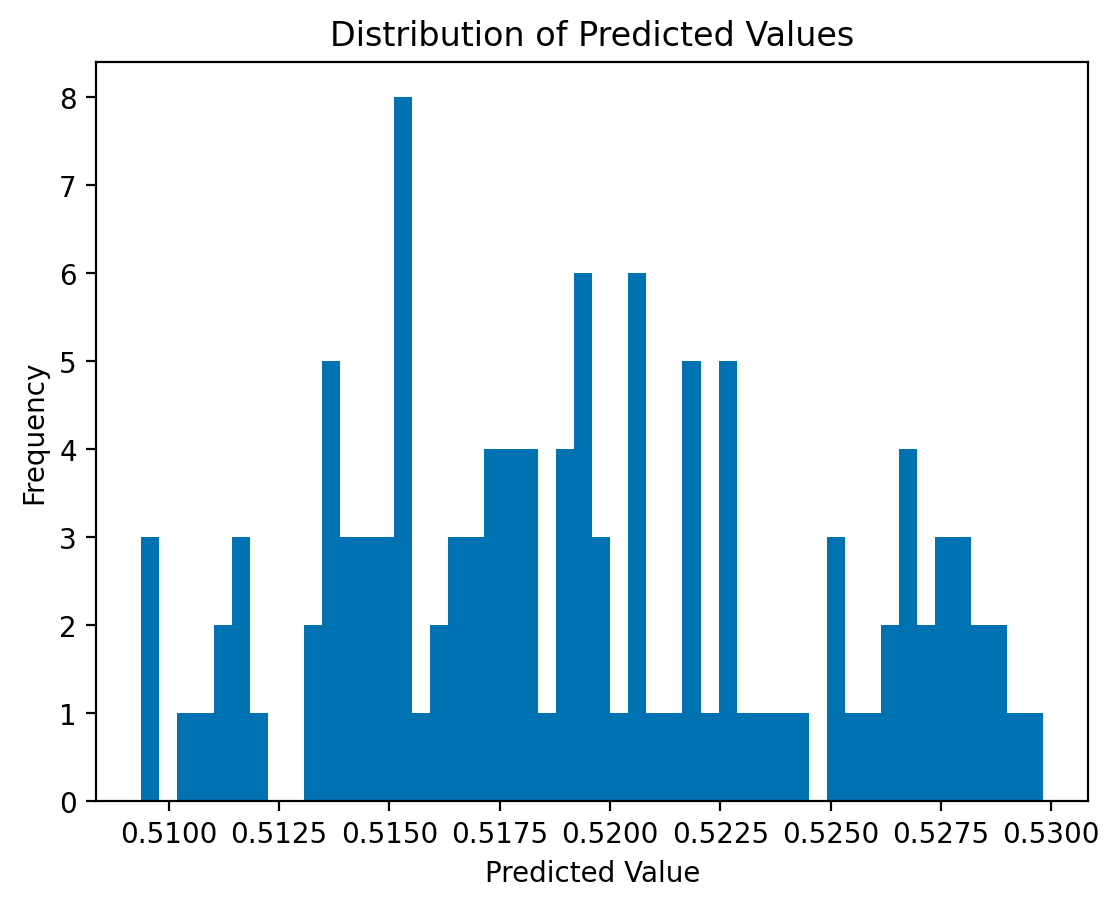

In [53]:
prediction = pred.flatten()
plt.hist(prediction, bins=50)
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Values")
plt.show()

In [54]:
# based on prediction calculate the position for strategy
trimmed_test = test[input_window:]
trimmed_test = trimmed_test.loc[:, ['returns', 'direction']]
trimmed_test['position_strategy'] = np.where(pred > np.mean(pred), 1, -1)
trimmed_test.tail(5)

,returns,direction,position_strategy
날짜,,,
2022-12-28,-0.011875,-1,1
2022-12-29,-0.018082,-1,1
2023-01-02,-0.005931,-1,1
2023-01-03,0.000000,0,1
2023-01-04,0.020855,1,1


In [55]:
# calculate daily returns for the strategy
trimmed_test['strategy_return'] = trimmed_test['position_strategy'] * (trimmed_test['returns'])

In [56]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(trimmed_test[['returns', 'strategy_return']].sum().apply(np.exp))


Total Returns:
returns            0.974692
strategy_return    1.164476
dtype: float64


In [57]:
# number of trades over time for the strategy
print('Number of trades = ', (trimmed_test['position_strategy'].diff()!=0).sum())

Number of trades =  9


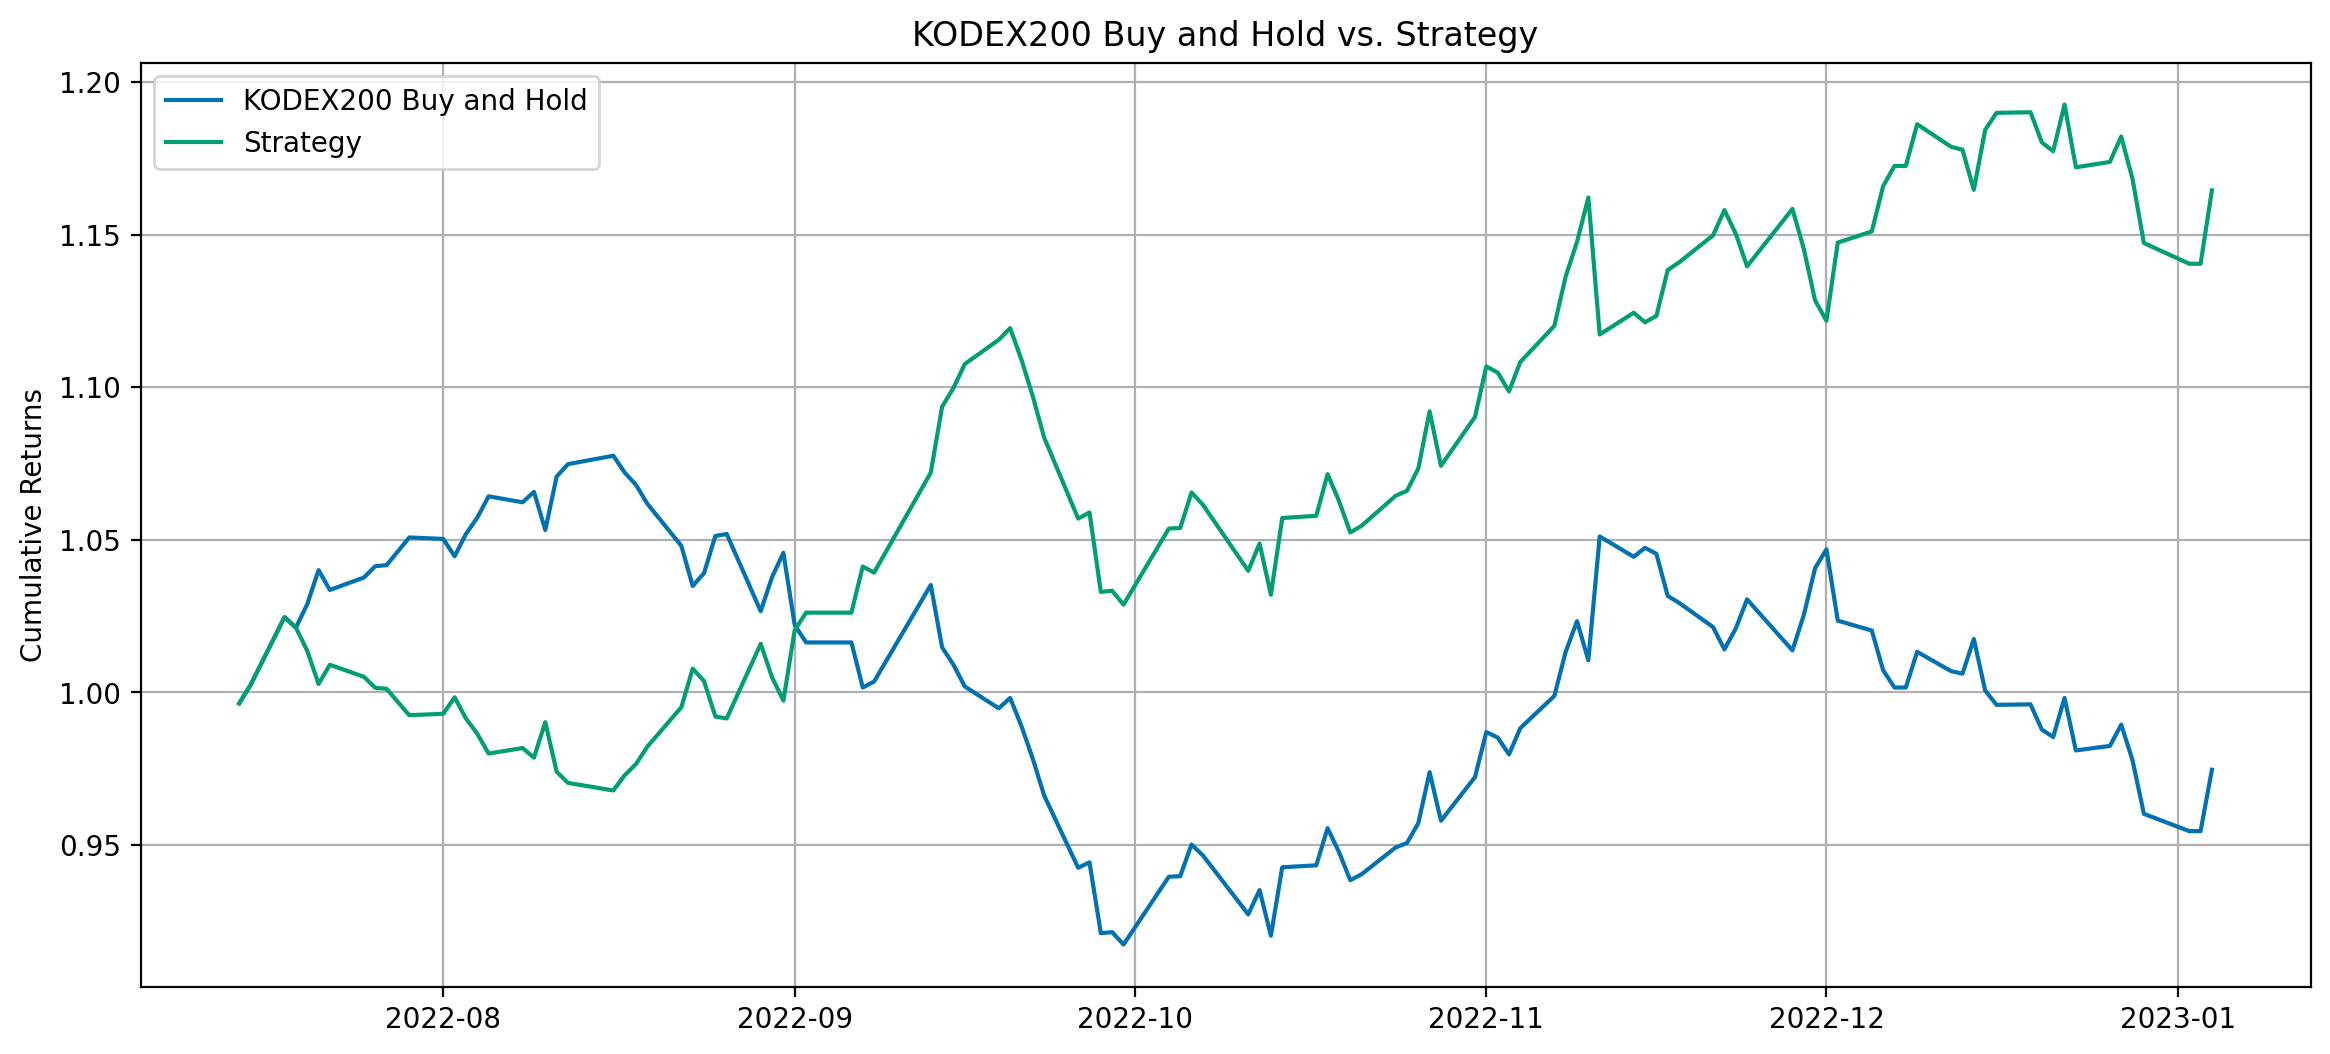

In [58]:
# plot cumulative returns
fig, ax = plt.subplots(1, 1, sharex=True, figsize = (14,6))
ax.plot(trimmed_test.returns.cumsum().apply(np.exp), label = 'KODEX200 Buy and Hold')
ax.plot(trimmed_test.strategy_return.cumsum().apply(np.exp), label = 'Strategy')
ax.set(title = 'KODEX200 Buy and Hold vs. Strategy', ylabel = 'Cumulative Returns')
ax.grid(True)
ax.legend()
plt.show()

### Backtesting using Backtrader

In [59]:
# backtesting start and end dates
start = test.index[0]
end = test.index[-1]
print(start)
print(end)

2022-07-11 00:00:00
2023-01-04 00:00:00


In [60]:
# fetch the daily pricing data from yahoo finance
prices = pd.read_csv('./Data/kodex200_data.csv')
prices.head(2)

,날짜,NAV,시가,고가,저가,종가,거래량,괴리율,추적오차율
0,2013-01-04,26950.53,27060,27080,26825,26870,5112298,-0.30,-0.01
1,2013-01-07,26927.29,26895,26930,26685,26885,4449424,-0.16,-0.03


In [61]:
prices['날짜'] = pd.to_datetime(prices['날짜'])
prices.set_index('날짜', inplace=True)

In [62]:
# rename the columns as needed for Backtrader
prices.drop(['NAV', '괴리율', '추적오차율'], inplace=True, axis=1)
prices.rename(columns = {'시가':'open','고가':'high','저가':'low','종가':'close','거래량':'volume',
                         }, inplace=True)

In [63]:
prices.head(3)

,open,high,low,close,volume
날짜,,,,,
2013-01-04,27060,27080,26825,26870,5112298
2013-01-07,26895,26930,26685,26885,4449424
2013-01-08,26755,26860,26600,26600,3925874


In [64]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = trimmed_test.strategy_return
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_return':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)

,predicted,open,high,low,close,volume
날짜,,,,,,
2022-07-14,-0.003575,30590,30935,30500,30710,5896627
2022-07-15,0.006006,30900,30935,30335,30895,7255044


In [65]:
prices[['predicted']].sum().apply(np.exp)

predicted    1.164476
dtype: float64

In [66]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [67]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [68]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
#                 self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
#                 self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [69]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [88]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [89]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
start_cash = cerebro.broker.getvalue()
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
final_cash = cerebro.broker.getvalue()

Starting Portfolio Value: 100000.00
2022-07-15, BUY EXECUTED --- Price: 30900.00, Cost: 92700.00,Commission: 9.27
2022-07-19, SELL EXECUTED --- Price: 31455.00, Cost: 92700.00,Commission: 9.44
2022-07-19, OPERATION RESULT --- Gross: 1665.00, Net: 1646.29
2022-07-22, BUY EXECUTED --- Price: 31985.00, Cost: 95955.00,Commission: 9.60
2022-07-25, SELL EXECUTED --- Price: 31750.00, Cost: 95955.00,Commission: 9.53
2022-07-25, OPERATION RESULT --- Gross: -705.00, Net: -724.12
2022-08-01, BUY EXECUTED --- Price: 32305.00, Cost: 96915.00,Commission: 9.69
2022-08-03, SELL EXECUTED --- Price: 32210.00, Cost: 96915.00,Commission: 9.66
2022-08-03, OPERATION RESULT --- Gross: -285.00, Net: -304.35
2022-08-08, BUY EXECUTED --- Price: 32575.00, Cost: 97725.00,Commission: 9.77
2022-08-09, SELL EXECUTED --- Price: 32750.00, Cost: 97725.00,Commission: 9.83
2022-08-09, OPERATION RESULT --- Gross: 525.00, Net: 505.40
2022-08-10, BUY EXECUTED --- Price: 32670.00, Cost: 98010.00,Commission: 9.80
2022-08-11, 

In [90]:
final_return = (final_cash-start_cash) / start_cash
print(final_return)

-0.032733480000000564


In [91]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2022-07-14 00:00:00+00:00    0.000000
2022-07-15 00:00:00+00:00   -0.000243
Name: Strategy, dtype: float64

In [74]:
# get benchmark returns
benchmark_rets= stock['returns']
#benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'KODEX200'
benchmark_rets.head()

Series([], Name: KODEX200, dtype: float64)

In [75]:
# get performance statistics for strategy
#pf.show_perf_stats(returns)

In [76]:
# # plot performance for strategy vs benchmark
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9),constrained_layout=True)

# #pf.plot_drawdown_periods(returns=returns, ax=axes[0])
# #ax[0].grid(True)
# #pf.plot_rolling_returns(returns=returns,
#                         factor_returns=benchmark_rets,
#                         title='Strategy vs KODEX200 Buy&Hold')
# #axes[1].grid(True)
# #pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
# #axes[2].grid(True)
# #pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
# #axes[3].grid(True)
# # fig.suptitle('XXX', fontsize=16, y=0.990)

# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

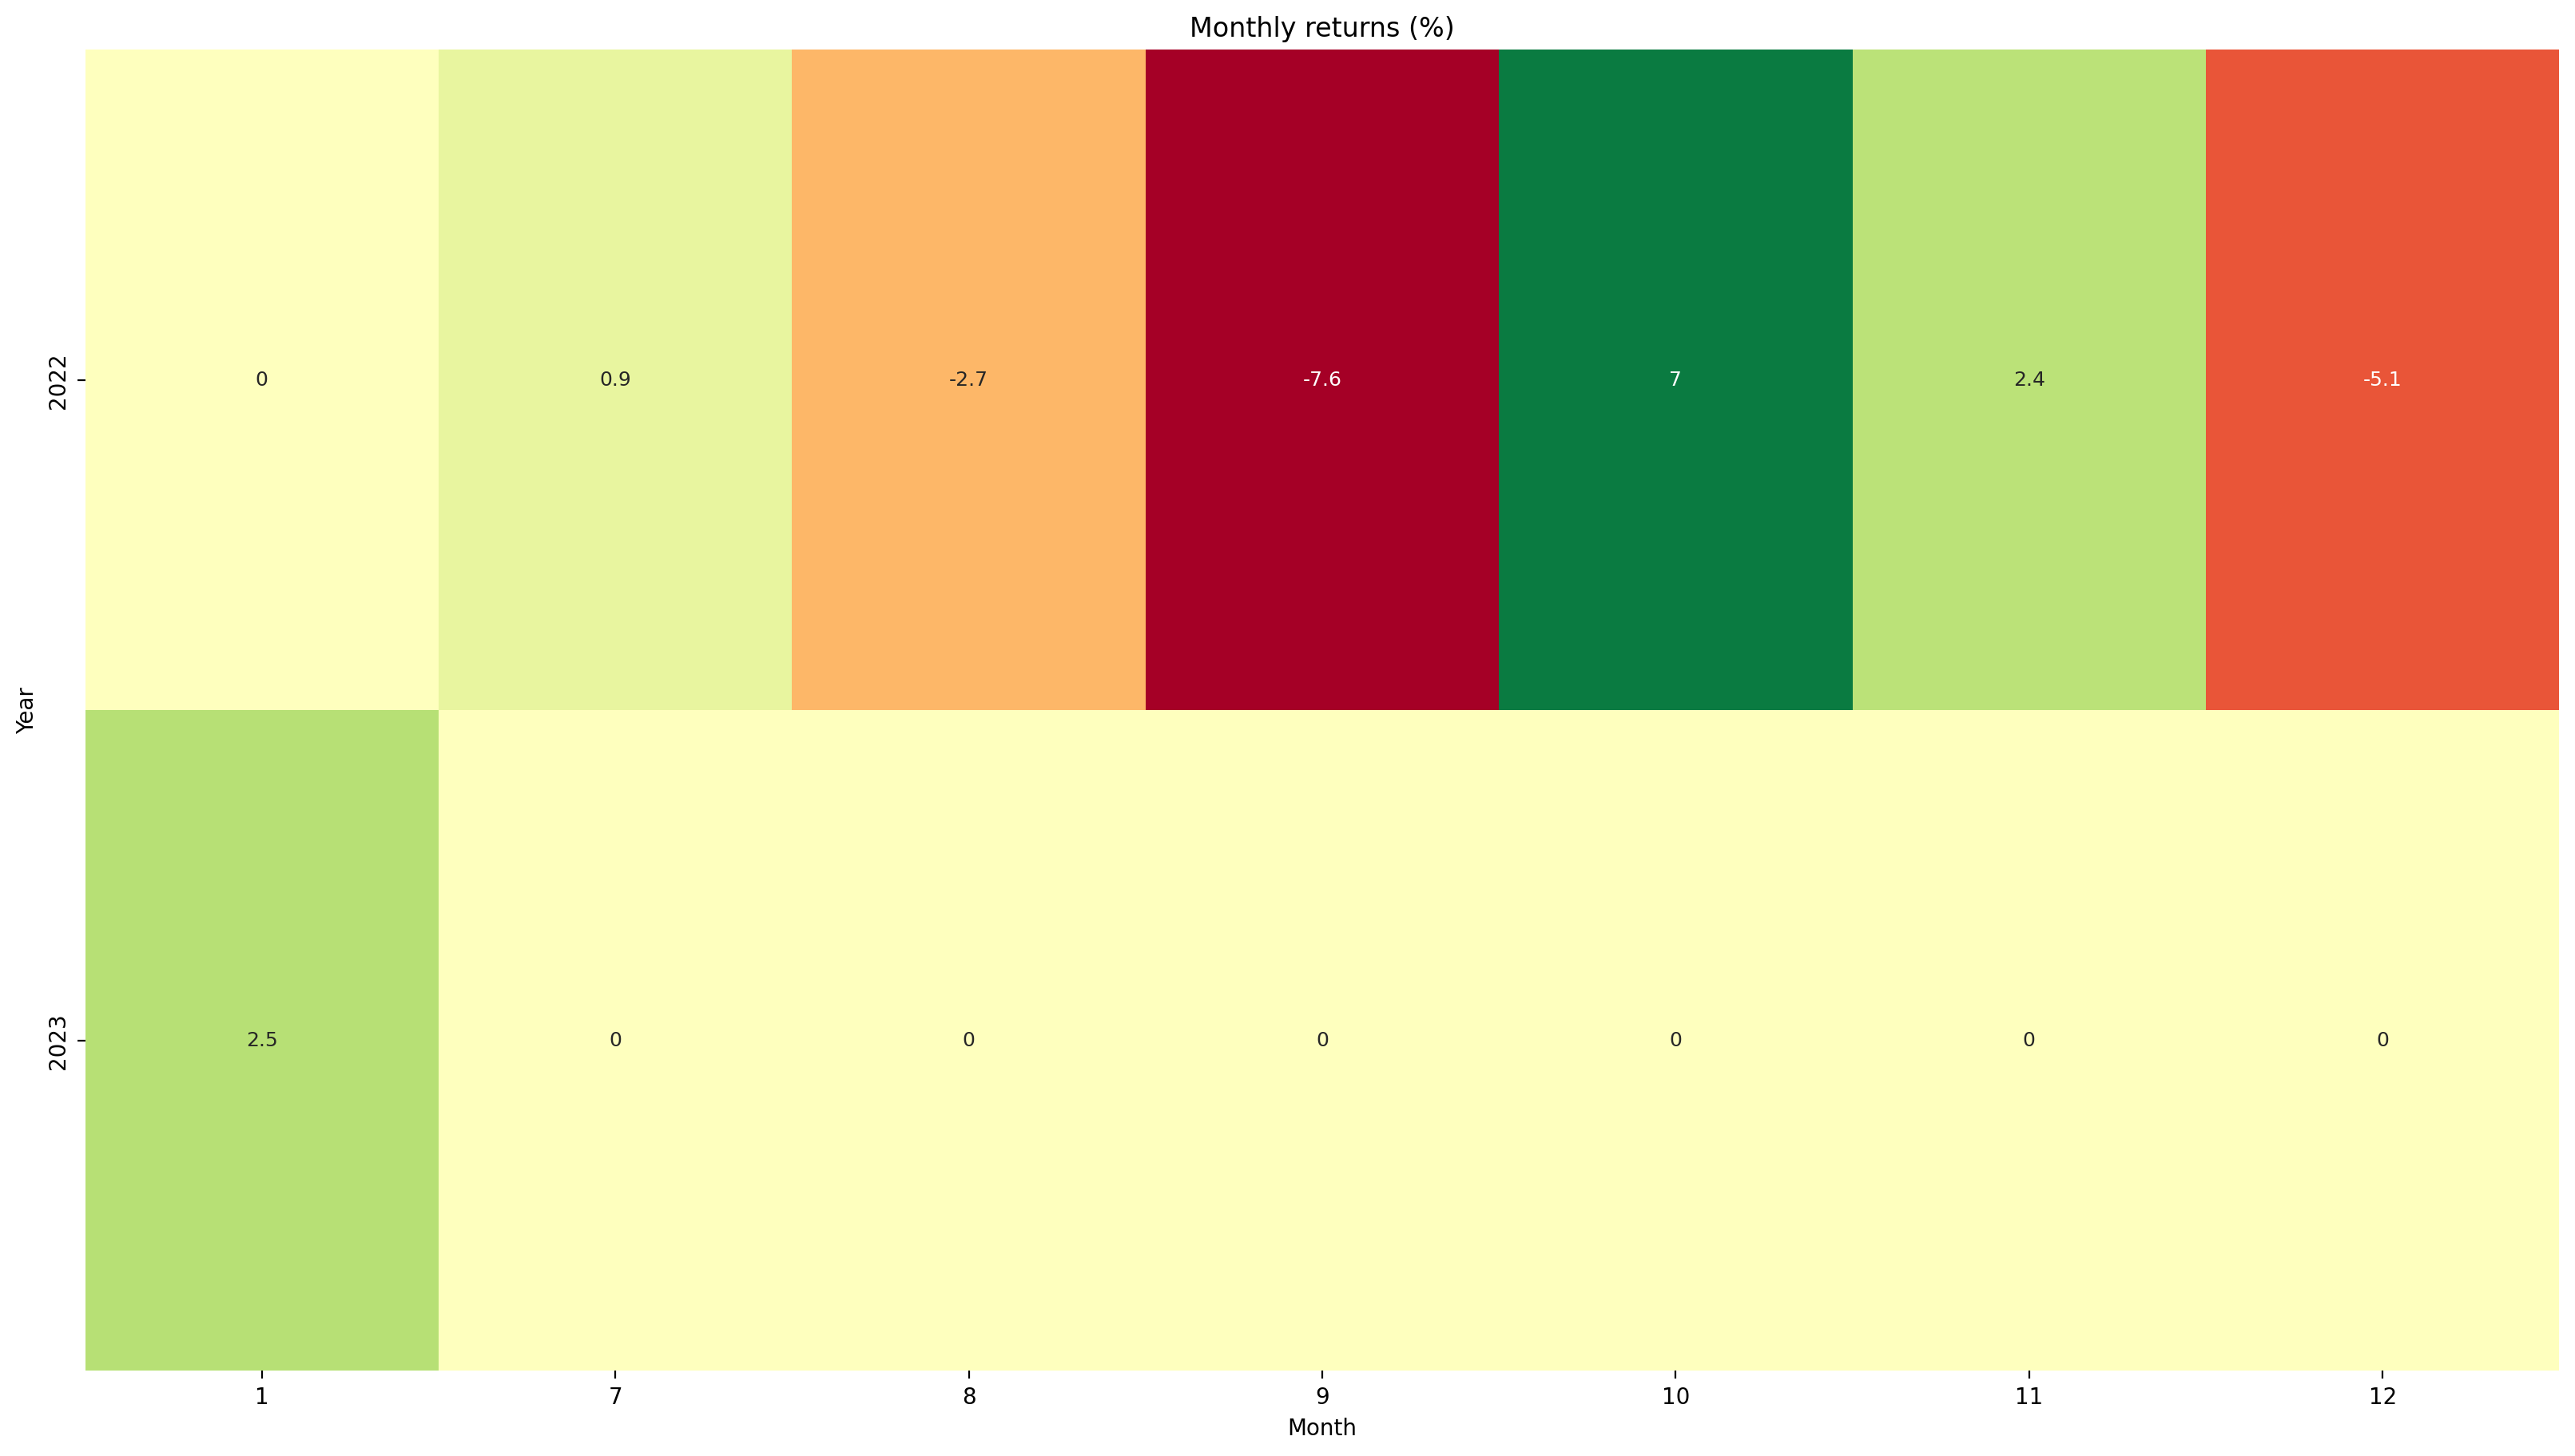

In [92]:
# plot performance for strategy vs benchmark
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9),constrained_layout=True)
# pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
# axes[0].grid(True)

# #pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
# axes[1].grid(True)

#pf.plot_annual_returns(returns=returns, ax=axes[0])
#axes[0].grid(True)

ax = pf.plot_monthly_returns_heatmap(returns=returns)


# Get the current annotations
annotations = ax.collections[0].get_children()

# Adjust the font size for numbers inside the heatmap
for annotation in annotations:
    annotation.set_fontsize(20)

# Show the plot
plt.show()